In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../../Data & Script/tommywilczek-walmart/"))

# Any results you write to the current directory are saved as output.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


['features.csv', 'myCity.csv', 'stores.csv', 'train.csv', 'walmart.csv', 'walmartSample.csv']


In [2]:
dataset = pd.read_csv("../../Data & Script/tommywilczek-walmart/train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("../../Data & Script/tommywilczek-walmart/features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("../../Data & Script/tommywilczek-walmart/stores.csv", names=['Store','Type','Size'],sep=',', header=0)
dataset = dataset.merge(stores, how='left').merge(features, how='left')

# dataset["nextWeekHoliday"] = dataset["isHoliday"].shift(-1).fillna(False)
# dataset["next2WeekHoliday"] = dataset["isHoliday"].shift(-2).fillna(False)
dataset.head()

,Store,Dept,Date,weeklySales,isHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


# Data exploration

In [3]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(dataset[column] , dataset['weeklySales'])
    plt.ylabel('weeklySales')
    plt.xlabel(column)

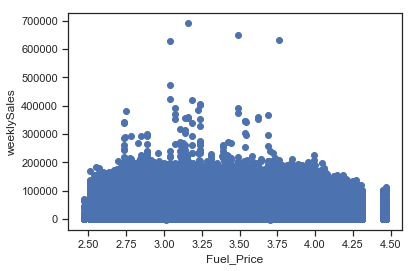

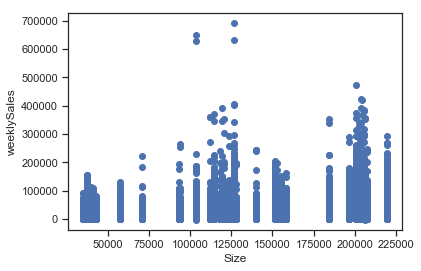

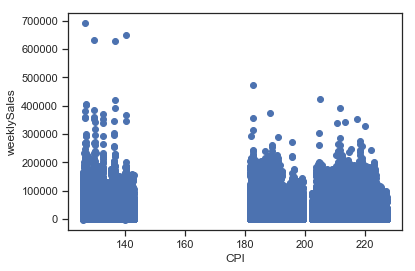

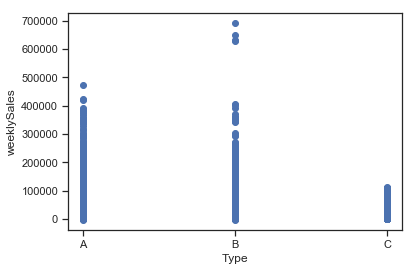

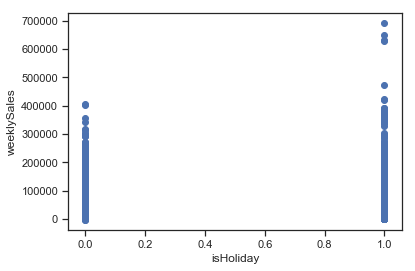

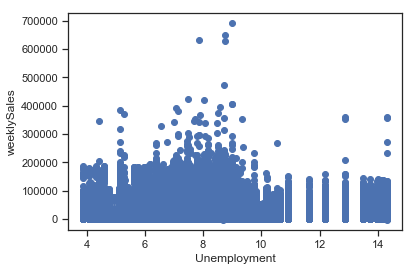

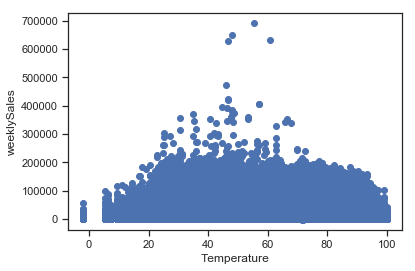

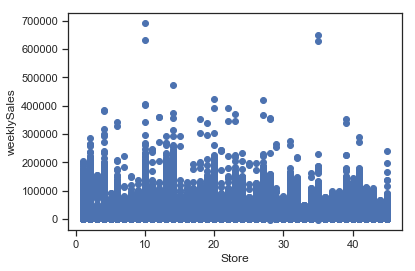

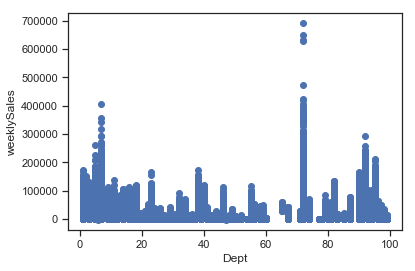

In [4]:
scatter(dataset, 'Fuel_Price')
scatter(dataset, 'Size')
scatter(dataset, 'CPI')
scatter(dataset, 'Type')
scatter(dataset, 'isHoliday')
scatter(dataset, 'Unemployment')
scatter(dataset, 'Temperature')
scatter(dataset, 'Store')
scatter(dataset, 'Dept')

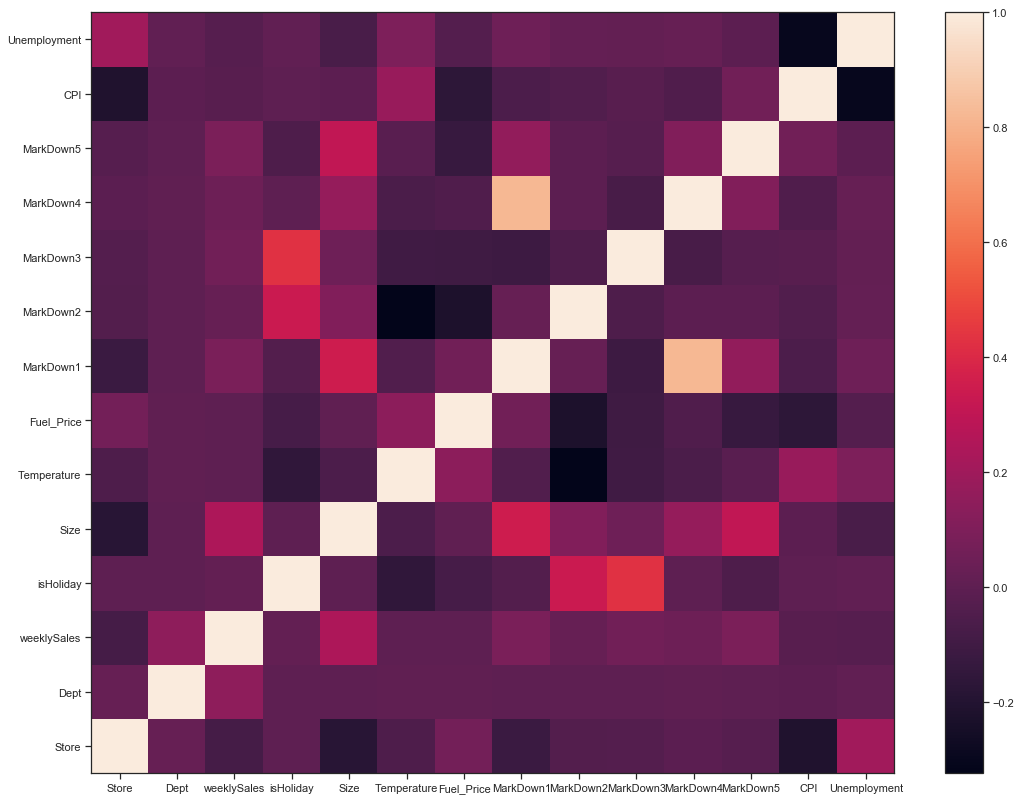

In [5]:
fig = plt.figure(figsize=(18, 14))
corr = dataset.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)

In [ ]:
sns.pairplot(dataset, vars=['weeklySales', 'Fuel_Price', 'Size', 'CPI', 'Dept', 'Temperature', 'Unemployment'])

In [ ]:
sns.pairplot(dataset.fillna(0), vars=['weeklySales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

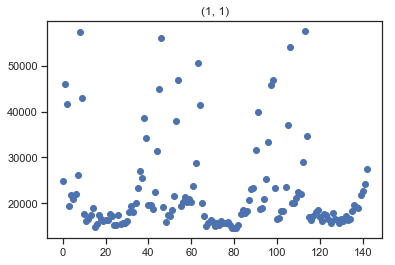

In [6]:
for name, group in dataset.groupby(["Store", "Dept"]):
    plt.title(name)
    plt.scatter(range(len(group)), group["weeklySales"])
    plt.show()
    break

# Data manipulation

In [7]:
dataset = pd.get_dummies(dataset, columns=["Type"])
dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
dataset = dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'MarkDown3'])
dataset

,Store,Dept,weeklySales,isHoliday,Size,Temperature,MarkDown1,MarkDown2,MarkDown4,MarkDown5,Type_A,Type_B,Type_C,Month
0,1,1,24924.50,False,151315,42.31,0.00,0.00,0.00,0.00,1,0,0,2
1,1,1,46039.49,True,151315,38.51,0.00,0.00,0.00,0.00,1,0,0,2
2,1,1,41595.55,False,151315,39.93,0.00,0.00,0.00,0.00,1,0,0,2
3,1,1,19403.54,False,151315,46.63,0.00,0.00,0.00,0.00,1,0,0,2
4,1,1,21827.90,False,151315,46.50,0.00,0.00,0.00,0.00,1,0,0,3
5,1,1,21043.39,False,151315,57.79,0.00,0.00,0.00,0.00,1,0,0,3
6,1,1,22136.64,False,151315,54.58,0.00,0.00,0.00,0.00,1,0,0,3
7,1,1,26229.21,False,151315,51.45,0.00,0.00,0.00,0.00,1,0,0,3
8,1,1,57258.43,False,151315,62.27,0.00,0.00,0.00,0.00,1,0,0,4
9,1,1,42960.91,False,151315,65.86,0.00,0.00,0.00,0.00,1,0,0,4


# Algorithms

In [8]:
def knn():
    knn = KNeighborsRegressor(n_neighbors=10)
    return knn

def extraTreesRegressor():
    clf = ExtraTreesRegressor(n_estimators=100,max_features='auto', verbose=1, n_jobs=1)
    return clf

def randomForestRegressor():
    clf = RandomForestRegressor(n_estimators=100,max_features='log2', verbose=1)
    return clf

def svm():
    clf = SVR(kernel='rbf', gamma='auto')
    return clf

def nn():
    clf = MLPRegressor(hidden_layer_sizes=(10,),  activation='relu', verbose=3)
    return clf

def predict_(m, test_x):
    return pd.Series(m.predict(test_x))

def model_():
#     return knn()
    return extraTreesRegressor()
#     return svm()
#     return nn()
#     return randomForestRegressor()    

def train_(train_x, train_y):
    m = model_()
    m.fit(train_x, train_y)
    return m

def train_and_predict(train_x, train_y, test_x):
    m = train_(train_x, train_y)
    return predict_(m, test_x), m

In [9]:
def calculate_error(test_y, predicted, weights):
    return mean_absolute_error(test_y, predicted, sample_weight=weights)

# K-Fold Cross Validation

In [17]:
kf = KFold(n_splits=5)
splited = []
# dataset2 = dataset.copy()
for name, group in dataset.groupby(["Store", "Dept"]):
    group = group.reset_index(drop=True)
    trains_x = []
    trains_y = []
    tests_x = []
    tests_y = []
    if group.shape[0] <= 5:
        f = np.array(range(5))
        np.random.shuffle(f)
        group['fold'] = f[:group.shape[0]]
        continue
    fold = 0
    for train_index, test_index in kf.split(group):
        group.loc[test_index, 'fold'] = fold
        fold += 1
    splited.append(group)

splited = pd.concat(splited).reset_index(drop=True)

In [11]:
splited.head()

,Store,Dept,weeklySales,isHoliday,Size,Temperature,MarkDown1,MarkDown2,MarkDown4,MarkDown5,Type_A,Type_B,Type_C,Month,fold
0,1,1,24924.50,False,151315,42.31,0.00,0.00,0.00,0.00,1,0,0,2,0.0
1,1,1,46039.49,True,151315,38.51,0.00,0.00,0.00,0.00,1,0,0,2,0.0
2,1,1,41595.55,False,151315,39.93,0.00,0.00,0.00,0.00,1,0,0,2,0.0
3,1,1,19403.54,False,151315,46.63,0.00,0.00,0.00,0.00,1,0,0,2,0.0
4,1,1,21827.90,False,151315,46.50,0.00,0.00,0.00,0.00,1,0,0,3,0.0
5,1,1,21043.39,False,151315,57.79,0.00,0.00,0.00,0.00,1,0,0,3,0.0
6,1,1,22136.64,False,151315,54.58,0.00,0.00,0.00,0.00,1,0,0,3,0.0
7,1,1,26229.21,False,151315,51.45,0.00,0.00,0.00,0.00,1,0,0,3,0.0
8,1,1,57258.43,False,151315,62.27,0.00,0.00,0.00,0.00,1,0,0,4,0.0
9,1,1,42960.91,False,151315,65.86,0.00,0.00,0.00,0.00,1,0,0,4,0.0


In [18]:
best_model = None
error_cv = 0
best_error = np.iinfo(np.int32).max
for fold in range(5):
    dataset_train = splited.loc[splited['fold'] != fold]
    dataset_test = splited.loc[splited['fold'] == fold]
    train_y = dataset_train['weeklySales']
    train_x = dataset_train.drop(columns=['weeklySales', 'fold'])
    test_y = dataset_test['weeklySales']
    test_x = dataset_test.drop(columns=['weeklySales', 'fold'])
    print(dataset_train.shape, dataset_test.shape)
    predicted, model = train_and_predict(train_x, train_y, test_x)
    weights = test_x['isHoliday'].replace(True, 5).replace(False, 1)
    error = calculate_error(test_y, predicted, weights)
    error_cv += error
    print(fold, error)
    if error < best_error:
        print('Find best model')
        best_error = error
        best_model = model
error_cv /= 5

(335722, 15) (85552, 15)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.2s finished


0 1998.1376000433263
Find best model
(335849, 15) (85425, 15)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished


1 3133.752064998064
(335970, 15) (85304, 15)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


2 1914.161168877781
Find best model
(338733, 15) (82541, 15)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.6s finished


3 2332.368839098099
(338822, 15) (82452, 15)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


4 1807.7181883473677
Find best model


In [19]:
error_cv

2237.2275722729273

In [20]:
best_error

1807.7181883473677

# Test part

In [22]:
dataset_test = pd.read_csv("../../Data & Script/tommywilczek-walmart/test.csv", names=['Store','Dept','Date','isHoliday'],sep=',', header=0)
features = pd.read_csv("../../Data & Script/tommywilczek-walmart/features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("../../Data & Script/tommywilczek-walmart/stores.csv", names=['Store','Type','Size'],sep=',', header=0)
dataset_test = dataset_test.merge(stores, how='left').merge(features, how='left')

In [23]:
dataset_test = pd.get_dummies(dataset_test, columns=["Type"])
dataset_test[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset_test[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset_test = dataset_test.fillna(0)
column_date = dataset_test['Date']
dataset_test['Month'] = pd.to_datetime(dataset_test['Date']).dt.month
dataset_test = dataset_test.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'MarkDown3'])
dataset_test

,Store,Dept,isHoliday,Size,Temperature,MarkDown1,MarkDown2,MarkDown4,MarkDown5,Type_A,Type_B,Type_C,Month
0,1,1,False,151315,55.32,6766.44,5147.70,3639.90,2737.42,1,0,0,11
1,1,1,False,151315,61.24,11421.32,3370.89,4646.79,6154.16,1,0,0,11
2,1,1,False,151315,52.92,9696.28,292.10,1133.15,6612.69,1,0,0,11
3,1,1,True,151315,56.23,883.59,4.17,209.91,303.32,1,0,0,11
4,1,1,False,151315,52.34,2460.03,0.00,150.57,6966.34,1,0,0,11
5,1,1,False,151315,64.12,6343.16,0.00,2928.90,10147.90,1,0,0,12
6,1,1,False,151315,48.89,3504.83,0.00,1636.80,2779.60,1,0,0,12
7,1,1,False,151315,56.02,8231.71,0.00,358.15,2834.02,1,0,0,12
8,1,1,True,151315,44.79,12659.55,37101.13,74.46,1208.86,1,0,0,12
9,1,1,False,151315,41.73,1214.08,25366.33,72.36,3940.02,1,0,0,1


In [24]:
predicted_test = best_model.predict(dataset_test)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished


In [25]:
dataset_test['weeklySales'] = predicted_test
dataset_test['Date'] = column_date
dataset_test['id'] = dataset_test['Store'].astype(str) + '_' +  dataset_test['Dept'].astype(str) + '_' +  dataset_test['Date'].astype(str)
dataset_test = dataset_test[['id', 'weeklySales']]
dataset_test = dataset_test.rename(columns={'id': 'Id', 'weeklySales': 'Weekly_Sales'})

In [26]:
dataset_test.to_csv('output.csv', index=False)